In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

#### Abstract
In this project, we implement a modified model for quantum neural network (QNN) proposed in Ref. [1]. We will describe the model in terms of a quantum circuit and explain how it works mathematically. When the QNN is compared with its classical counterpart, we will see that the main difference between them lies in the nature of their **activation functions**.

# I. Introduction
Neural networks (NN) are composed of many non-linear components that mimic the learning mechanism of a human brain. The training is done by adjusting the weights and biases applied to the input parameters. The computational advantage (speed-up) of QNN over classical NN has been discussed in Ref. [1] and hence it will not be emphasized here. In this project, we simply focus on the implementation of our QNN and its mathematical formulation. The Task for our QNN is to categorize irises among the given data set imported from `sklearn`:

In [94]:
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [3]:
X = iris.data   #input data
D = iris.target #output data
print(X.shape, D.shape)

(150, 4) (150,)


Before we go on to the formulation of our QNN model, keeping the classical counterpart in mind will help to understand the whole story: **The classical NN contains only $1$ hidden layer, which has only $2$ hidden neurons** (Of course one may consider more hidden neurons, but we use two for simplicity). For example, the diagram of a 2-input model is shown below:

![](NN.png)

Note that there are no weights or biases between the hidden layer and the output layer.

# II. The Quantum Circuit for QNN

![](QNN.png)

The above plot is a compact diagram of the QNN circuit. In the following sections, we will implement three models: one is a $2$-input network **without** biases, another one is a $2$-input network **with** biases, and the other is a $4$-input network **with** biases.
### A. $2$-input Unbiased QNN
Consider the operation 

$$U_{x_1} \equiv \begin{bmatrix} { e }^{ i{ w }_{ 11 }{ x }_{ 1 } } & 0 \\ 0 & { e }^{ i{ w }_{ 12 }{ x }_{ 1 } } \end{bmatrix}.$$

To implement such a gate in `qiskit`, we have to decompose it into

$$U_{x_1}=X\,U_1({ w }_{ 11 }{ x }_{ 1 })\,X\,U_1({ w }_{ 12 }{ x }_{ 1 })=\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}\begin{bmatrix} 1 & 0 \\ 0 & { e }^{ i{ w }_{ 11 }{ x }_{ 1 } } \end{bmatrix}\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}\begin{bmatrix} 1 & 0 \\ 0 & { e }^{ i{ w }_{ 12 }{ x }_{ 1 } } \end{bmatrix},$$

where $U_1(\theta)$ is one of the elementary operations in `qiskit` defined by

$$U_1(\theta)=\begin{bmatrix} 1 & 0 \\ 0 & { e }^{ i\theta  } \end{bmatrix}.$$

The gate $U(w,x)$ in the $2$-input Unbiased QNN is therefore 

$$U(w,x)=U_{x_1}\otimes U_{x_2}=\begin{bmatrix} { e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) } & 0 & 0 & 0 \\ 0 & { e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) } & 0 & 0 \\ 0 & 0 & { e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) } & 0 \\ 0 & 0 & 0 & { e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) } \end{bmatrix}. $$

A more detailed visualization of the circuit is shown below:

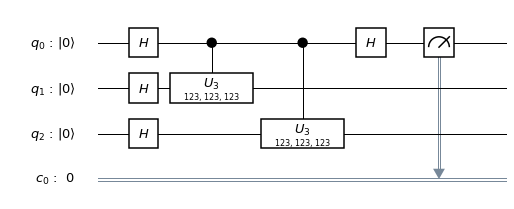

In [103]:
Q = QuantumRegister(3, 'q')
C = ClassicalRegister(1, 'c')

circuit = QuantumCircuit(Q, C)

circuit.h(range(3))
circuit.cu3(123, 123, 123, 0, 1)
circuit.cu3(123, 123, 123, 0, 2)
circuit.h(0)
circuit.measure(0, 0)

circuit.draw(output='mpl')

The first controlled-$U_3$ operation corresponds to controlled-$U_{x_1}$, and the second corresponds to controlled-$U_{x_2}$. Now we go through the circuit step by step. First, we initialize the qubits in the state

$$H\left| 0 \right>\otimes H^{\otimes 2} \left| 0  \right> =\frac { \left| 0 \right> +\left| 1 \right>  }{ \sqrt { 2 }  } \otimes \frac { 1 }{ \sqrt { 4 }  } \sum _{ j=0 }^{ 3 }{ \left| j \right>  }. $$

After the controlled-$U(w,x)$ gate, the state becomes

$$\frac { 1 }{ \sqrt { 8 }  } \left| 0 \right> \sum _{ j=0 }^{ 3 }{ \left| j \right>  } +\frac { 1 }{ \sqrt { 8 }  } \left| 1 \right> \sum _{ j=0 }^{ 3 }{ U(w,x)\left| j \right>  }. $$

Finally, after applying the Hadamard gate, we have

$ \frac { \left| 0 \right> +\left| 1 \right>  }{ 4 } \sum _{ j=0 }^{ 3 }{ \left| j \right>  } +\frac { \left| 0 \right> -\left| 1 \right>  }{ 4 } \sum _{ j=0 }^{ 3 }{ U(w,x)\left| j \right>  }   $

$=  \frac { \left| 0 \right>  }{ 4 } \sum _{ j=0 }^{ 3 }{ \left[ I+U(w,x) \right] \left| j \right>  } +\frac { \left| 1 \right>  }{ 4 } \sum _{ j=0 }^{ 3 }{ \left[ I-U(w,x) \right] \left| j \right>  }  $

$=  \frac { \left| 0 \right>  }{ 4 } \left\{ [1+{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 0 \right> +[1+{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 1 \right> +[1+{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 2 \right> +[1+{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 3 \right>  \right\} +\\\,\,\,\,\frac { \left| 1 \right>  }{ 4 } \left\{ [1-{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 0 \right> +[1-{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 1 \right> +[1-{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 2 \right> +[1-{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 3 \right>  \right\}  $

If we measure the first qubit, then the probability that we obtain $1$ will be

$$P^1=\frac { 1 }{ 16 } \left[ { \left| 1-{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) } \right|  }^{ 2 }+{ \left| 1-{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) } \right|  }^{ 2 }+{ \left| 1-{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) } \right|  }^{ 2 }+{ \left| 1-{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) } \right|  }^{ 2 } \right]. $$

Since ${ \left| 1-{ e }^{ i\theta  } \right|  }^{ 2 }=(1-{ e }^{ i\theta  })(1-{ e }^{ -i\theta  })=2(1-\cos { \theta  } )$, we have

$$P^1 = \frac { 1 }{ 8 } \left[ 4-\cos { ({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) } -\cos { ({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) } -\cos { ({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) } -\cos { ({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }  \right]. $$

As for the output of the neural network, we simply let $z=P^1$ because our task is to classify $2$ kinds of irises labeled $0$ and $1$ respectively. The QNN hence makes pedictions

$$\begin{cases} 0,\,\mathrm{if}\,z\le 0.5 \\ 1,\,\mathrm{if}\,z>0.5 \end{cases}.$$

The workflow of what we have done so far is summarized in the following diagram:

![](qnn2.png)

From this, the main difference between our QNN and its classical counterpart is clear: the activation functions are always periodic (i.e., always sine or cosine) in QNN.

Now the QNN has been constructed, so here comes the crucial part––learning/training. We define the loss function by

$$L=\frac { 1 }{ 2s } \sum _{ j=1 }^{ s }{ { ({ z }_{ j }-{ d }_{ j }) }^{ 2 } } ,$$

the *mean squared error* (MSE), where $s$ is the size of a batch (We train our QNN on batches.) and $d$ is the target value (the desired output).

The weights are updated according to

$${ w }_{ i }\,\longrightarrow\, { w }_{ i }-\eta \frac { \partial L }{ \partial { w }_{ i } }, $$

where $\eta$ is the learning rate. This whole process is called *stochastic gradient descent*. The derivative $\frac { \partial L }{ \partial { w }_{ i } }$ is easy to compute. For example,

$$\begin{eqnarray} \frac { \partial L }{ \partial { w }_{ 11 } }  & = & \frac { 1 }{ s } \sum _{ j=1 }^{ s }{ ({ z }_{ j }-{ d }_{ j })\frac { \partial { z }_{ j } }{ \partial { w }_{ 11 } }  }  \\  & = & \frac { 1 }{ s } \sum _{ j=1 }^{ s }{ ({ z }_{ j }-{ d }_{ j })\frac { 1 }{ 8 } \left[ \sin { ({ w }_{ 11 }{ x }^j_{1 }+{ w }_{ 21 }{ x }^j_{ 2 }) } +\sin { ({ w }_{ 11 }{ x }^j_{ 1 }+{ w }_{ 22 }{ x }^j_{ 2 }) }  \right] { x }^j_{ 1 } }  \end{eqnarray}$$

How do we tackle those annoying sines appearing in $\frac { \partial L }{ \partial { w }_{ i } }$? Well, if we implement the same circuit with an additional phase gate $S$ (as shown below),

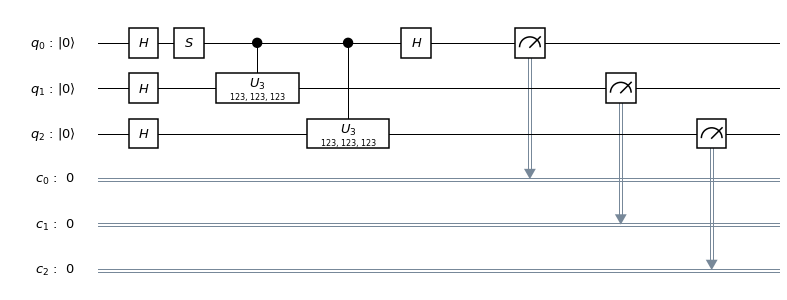

In [107]:
Q = QuantumRegister(3, 'q')
C = ClassicalRegister(3, 'c')

circuit = QuantumCircuit(Q, C)

circuit.h(range(3))
circuit.s(0)
circuit.cu3(123, 123, 123, 0, 1)
circuit.cu3(123, 123, 123, 0, 2)
circuit.h(0)
circuit.barrier(Q)
circuit.measure(range(3), range(3))

circuit.draw(output='mpl', plot_barriers=False)

then we will have an output state

$$\frac { \left| 0 \right>  }{ 4 } \left\{ [1+i{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 0 \right> +[1+i{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 1 \right> +[1+i{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 2 \right> +[1+i{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 3 \right>  \right\} +  \frac { \left| 1 \right>  }{ 4 } \left\{ [1-i{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 0 \right> +[1-i{ e }^{ i({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 1 \right> +[1-i{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }]\left| 2 \right> +[1-i{ e }^{ i({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }]\left| 3 \right>  \right\} .$$

Since ${ \left| 1-i{ e }^{ i\theta  } \right|  }^{ 2 }=(1-i{ e }^{ i\theta  })(1+i{ e }^{ -i\theta  })=2(1+\sin { \theta  } )$, we have

$$\begin{cases} { P }_{ 0 }^{ 1 }=\frac { 1 }{ 8 } \left[ 1+\sin { ({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }  \right]  \\ { P }_{ 1 }^{ 1 }=\frac { 1 }{ 8 } \left[ 1+\sin { ({ w }_{ 11 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }  \right]  \\ { P }_{ 2 }^{ 1 }=\frac { 1 }{ 8 } \left[ 1+\sin { ({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 21 }{ x }_{ 2 }) }  \right]  \\ { P }_{ 3 }^{ 1 }=\frac { 1 }{ 8 } \left[ 1+\sin { ({ w }_{ 12 }{ x }_{ 1 }+{ w }_{ 22 }{ x }_{ 2 }) }  \right]  \end{cases}.$$

The derivatives are hence

$$\begin{cases} \frac { \partial L }{ \partial { w }_{ 11 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 0 }^{ 1 }+{ P }_{ 1 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 1 } }  \\ \frac { \partial L }{ \partial { w }_{ 12 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 2 }^{ 1 }+{ P }_{ 3 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 1 } }  \\ \frac { \partial L }{ \partial { w }_{ 21 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 0 }^{ 1 }+{ P }_{ 2 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 2 } }  \\ \frac { \partial L }{ \partial { w }_{ 22 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 1 }^{ 1 }+{ P }_{ 3 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 2 } }  \end{cases}.$$

#### [Model 1] Input Features: Petal Width & Petal Length

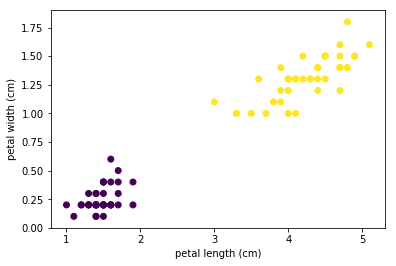

Epoch 0: Loss = 0.0206013620
Epoch 1: Loss = 0.0115800500
Epoch 2: Loss = 0.0147680640
Epoch 3: Loss = 0.0139822662
Epoch 4: Loss = 0.0157027543
Training Acc = 100.00%
Testing Acc = 100.00%


In [4]:
x = X[D<2][:, -2:]
d = D[D<2]

x_train, x_test, d_train, d_test = train_test_split(x, d, test_size=0.2, random_state=5487)

plt.scatter(x_train[:,0], x_train[:,1], c=d_train)
plt.xlabel(iris.feature_names[-2])
plt.ylabel(iris.feature_names[-1])
plt.show()

x_train = (x_train-x.min())/(x.max()-x.min())
x_test = (x_test-x.min())/(x.max()-x.min())

#np.random.seed(12)

input_dim = x.shape[1]
output_dim = 1
m = 1                                #k=2**m hidden neurons
q = output_dim + m*input_dim         #total number of qubits
N = 1024
batch_size = 16
epoch = 5
η = 5                                #learning rate

w = np.random.randn(2**m, input_dim) #random initial weights

Q = QuantumRegister(q, 'q')
C = ClassicalRegister(q+output_dim, 'c')
simulator = Aer.get_backend('qasm_simulator')

def QNN(x):
    '''Unbiased QNN: x = np.array([x1,x2])'''
    circuit = QuantumCircuit(Q, C)
    wx = w*x

    circuit.h(range(q))
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.h(0)
    circuit.measure(0, 0)

    circuit.reset(Q)

    circuit.h(range(q))
    circuit.s(0)
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.h(0)
    circuit.measure(range(q), range(1,q+1))

    job = execute(circuit, simulator, shots=N)
    result = job.result()
    counts = result.get_counts(circuit)

    z = 0
    for i in counts:
        if i.endswith('1'): z += counts[i]/N
    
    return z, counts

for j in range(epoch):
    indices = np.random.choice(len(x_train), len(x_train), replace=False)
    for k in range(len(x_train)//batch_size):
        L, L_prime = 0, np.zeros(input_dim*2**m)
        for idx in indices[k*batch_size:(k+1)*batch_size]:
            z, counts = QNN(x_train[idx])
            z_prime = -0.25*np.ones(input_dim*2**m)
            for i in counts:
                if i.endswith('1', -2, -1):
                    if int(i[:2],2)==0: z_prime[[0,2]] += counts[i]/N
                    elif int(i[:2],2)==1: z_prime[[0,3]] += counts[i]/N
                    elif int(i[:2],2)==2: z_prime[[1,2]] += counts[i]/N
                    else: z_prime[[1,3]] += counts[i]/N

            L_prime += (z-d_train[idx])*z_prime*x_train[idx][[0,0,1,1]]/batch_size
            L += 0.5*(z-d_train[idx])**2 / batch_size
        w -= η*L_prime.reshape(w.shape).T
    print('Epoch %d: Loss = %.10f' % (j,L))
    #print(w)

acc = 0
for idx in range(len(x_train)):
    z, counts = QNN(x_train[idx])
    if round(z)==d_train[idx]: acc += 1/len(x_train) * 100    
print('Training Acc = %.2f%%' % acc)

acc = 0
for idx in range(len(x_test)):
    z, counts = QNN(x_test[idx])
    if round(z)==d_test[idx]: acc += 1/len(x_test) * 100
print('Testing Acc = %.2f%%' % acc)

#### [Model 2] Input Features: Sepal Width & Sepal Length

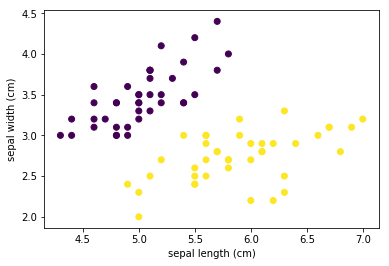

Epoch 0: Loss = 0.1956299543
Epoch 1: Loss = 0.1199962795
Epoch 2: Loss = 0.0942521095
Epoch 3: Loss = 0.0850783587
Epoch 4: Loss = 0.0947985053
Training Acc = 83.75%
Testing Acc = 95.00%


In [5]:
x = X[D<2][:, :2]
d = D[D<2]

x_train, x_test, d_train, d_test = train_test_split(x, d, test_size=0.2, random_state=5487)

plt.scatter(x_train[:,0], x_train[:,1], c=d_train)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

x_train = (x_train-x.min())/(x.max()-x.min())
x_test = (x_test-x.min())/(x.max()-x.min())

#np.random.seed(12)

input_dim = x.shape[1]
output_dim = 1
m = 1                                #k=2**m hidden neurons
q = output_dim + m*input_dim         #total number of qubits
N = 1024
batch_size = 16
epoch = 5
η = 5                                #learning rate

w = np.random.randn(2**m, input_dim) #random initial weights

Q = QuantumRegister(q, 'q')
C = ClassicalRegister(q+output_dim, 'c')
simulator = Aer.get_backend('qasm_simulator')

def QNN(x):
    '''Unbiased QNN: x = np.array([x1,x2])'''
    circuit = QuantumCircuit(Q, C)
    wx = w*x

    circuit.h(range(q))
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.h(0)
    circuit.measure(0, 0)

    circuit.reset(Q)

    circuit.h(range(q))
    circuit.s(0)
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.h(0)
    circuit.measure(range(q), range(1,q+1))

    job = execute(circuit, simulator, shots=N)
    result = job.result()
    counts = result.get_counts(circuit)

    z = 0
    for i in counts:
        if i.endswith('1'): z += counts[i]/N
    
    return z, counts

for j in range(epoch):
    indices = np.random.choice(len(x_train), len(x_train), replace=False)
    for k in range(len(x_train)//batch_size):
        L, L_prime = 0, np.zeros(input_dim*2**m)
        for idx in indices[k*batch_size:(k+1)*batch_size]:
            z, counts = QNN(x_train[idx])
            z_prime = -0.25*np.ones(input_dim*2**m)
            for i in counts:
                if i.endswith('1', -2, -1):
                    if int(i[:2],2)==0: z_prime[[0,2]] += counts[i]/N
                    elif int(i[:2],2)==1: z_prime[[0,3]] += counts[i]/N
                    elif int(i[:2],2)==2: z_prime[[1,2]] += counts[i]/N
                    else: z_prime[[1,3]] += counts[i]/N

            L_prime += (z-d_train[idx])*z_prime*x_train[idx][[0,0,1,1]]/batch_size
            L += 0.5*(z-d_train[idx])**2 / batch_size
        w -= η*L_prime.reshape(w.shape).T
    print('Epoch %d: Loss = %.10f' % (j,L))
    #print(w)

acc = 0
for idx in range(len(x_train)):
    z, counts = QNN(x_train[idx])
    if round(z)==d_train[idx]: acc += 1/len(x_train) * 100    
print('Training Acc = %.2f%%' % acc)

acc = 0
for idx in range(len(x_test)):
    z, counts = QNN(x_test[idx])
    if round(z)==d_test[idx]: acc += 1/len(x_test) * 100
print('Testing Acc = %.2f%%' % acc)

### B. $2$-input biased QNN
Biases may be easily included in our QNN by simply adding the gate

$$U_b = \begin{bmatrix} { e }^{ i{ b }_{ 1 } } & 0 \\ 0 & { e }^{ i{ b }_{ 2 } } \end{bmatrix}.$$

That is, 

$$U(w,b,x)=U_{x_1}\otimes U_{x_2}\otimes U_b.$$

A more detailed visualization of the circuit is shown below:

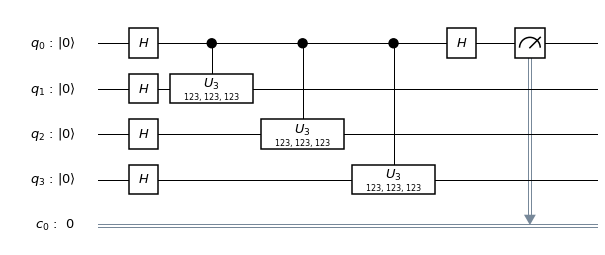

In [111]:
Q = QuantumRegister(4, 'q')
C = ClassicalRegister(1, 'c')

circuit = QuantumCircuit(Q, C)

circuit.h(range(4))
circuit.cu3(123, 123, 123, 0, 1)
circuit.cu3(123, 123, 123, 0, 2)
circuit.cu3(123, 123, 123, 0, 3)
circuit.h(0)
circuit.measure(0, 0)

circuit.draw(output='mpl')

The first controlled-$U_3$ operation corresponds to controlled-$U_{x_1}$, the second corresponds to controlled- $U_{x_2}$, and the third corresponds to controlled-$U_b$ .

Through a similar circuit (shown below) as in the unbiased case,

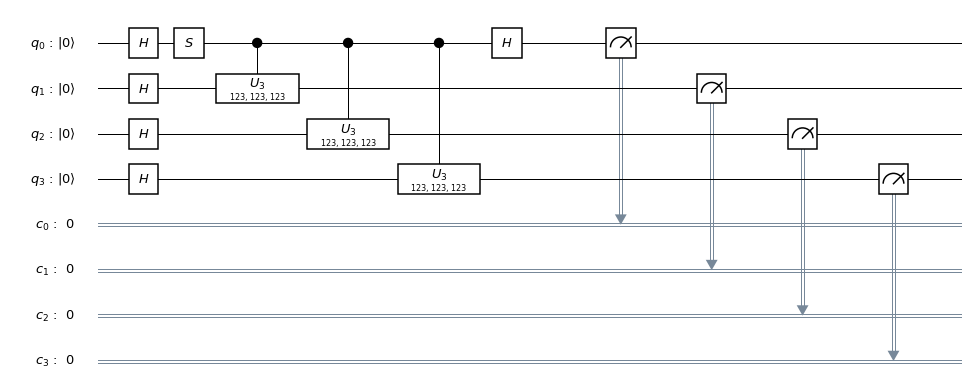

In [115]:
Q = QuantumRegister(4, 'q')
C = ClassicalRegister(4, 'c')

circuit = QuantumCircuit(Q, C)

circuit.h(range(4))
circuit.s(0)
circuit.cu3(123, 123, 123, 0, 1)
circuit.cu3(123, 123, 123, 0, 2)
circuit.cu3(123, 123, 123, 0, 3)
circuit.h(0)
circuit.barrier(Q)
circuit.measure(range(4), range(4))

circuit.draw(output='mpl', plot_barriers=False)

we can obtain

$$\begin{cases} \frac { \partial L }{ \partial { w }_{ 11 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 0 }^{ 1 }+{ P }_{ 1 }^{ 1 }+{ P }_{ 2 }^{ 1 }+{ P }_{ 3 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 1 } }  \\ \frac { \partial L }{ \partial { w }_{ 12 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 4 }^{ 1 }+{ P }_{ 5 }^{ 1 }+{ P }_{ 6 }^{ 1 }+{ P }_{ 7 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 1 } }  \\ \frac { \partial L }{ \partial { w }_{ 21 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 0 }^{ 1 }+{ P }_{ 1 }^{ 1 }+{ P }_{ 4 }^{ 1 }+{ P }_{ 5 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 2 } }  \\ \frac { \partial L }{ \partial { w }_{ 22 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 2 }^{ 1 }+{ P }_{ 3 }^{ 1 }+{ P }_{ 6 }^{ 1 }+{ P }_{ 7 }^{ 1 }-\frac { 1 }{ 4 }  \right) { x }^j_{ 2 } }  \\ \frac { \partial L }{ \partial { b }_{ 1 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 0 }^{ 1 }+{ P }_{ 2 }^{ 1 }+{ P }_{ 4 }^{ 1 }+{ P }_{ 6 }^{ 1 }-\frac { 1 }{ 4 }  \right)  }  \\ \frac { \partial L }{ \partial { b }_{ 2 } } =\frac { 1 }{ s } \sum { ({ z }_{ j }-{ d }_{ j })\left( { P }_{ 1 }^{ 1 }+{ P }_{ 3 }^{ 1 }+{ P }_{ 5 }^{ 1 }+{ P }_{ 7 }^{ 1 }-\frac { 1 }{ 4 }  \right)  }  \end{cases}.$$

#### [Model 3] Input Features: Petal Width & Petal Length

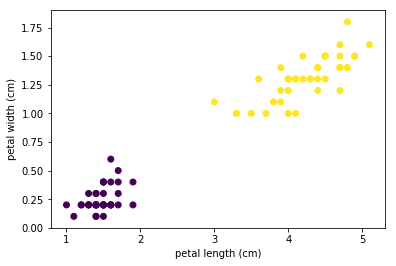

Epoch 0: Loss = 0.1664802730
Epoch 1: Loss = 0.0644763708
Epoch 2: Loss = 0.0565638542
Epoch 3: Loss = 0.0464445651
Epoch 4: Loss = 0.0467461050
Training Acc = 100.00%
Testing Acc = 100.00%


In [39]:
x = X[D<2][:, -2:]
d = D[D<2]

x_train, x_test, d_train, d_test = train_test_split(x, d, test_size=0.2, random_state=5487)

plt.scatter(x_train[:,0], x_train[:,1], c=d_train)
plt.xlabel(iris.feature_names[-2])
plt.ylabel(iris.feature_names[-1])
plt.show()

x_train = (x_train-x.min())/(x.max()-x.min())
x_test = (x_test-x.min())/(x.max()-x.min())

#np.random.seed(12)

input_dim = x.shape[1]
output_dim = 1
m = 1                                #k=2**m hidden neurons
q = output_dim + m*input_dim + m     #total number of qubits
N = 1024
batch_size = 16
epoch = 5
η = 2                                #learning rate

w = np.random.randn(2**m, input_dim) #random initial weights
b = np.random.randn(2**m)            #random initial biases


Q = QuantumRegister(q, 'q')
C = ClassicalRegister(q+output_dim, 'c')
simulator = Aer.get_backend('qasm_simulator')

def QNN(x):
    '''Biased QNN: x = np.array([x1,x2])'''
    circuit = QuantumCircuit(Q, C)
    wx = w*x

    circuit.h(range(q))
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.cx(0, 3)
    circuit.cu1(b[0], 0, 3)
    circuit.cx(0, 3)
    circuit.cu1(b[1], 0, 3)
    circuit.h(0)
    circuit.measure(0, 0)

    circuit.reset(Q)

    circuit.h(range(q))
    circuit.s(0)
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.cx(0, 3)
    circuit.cu1(b[0], 0, 3)
    circuit.cx(0, 3)
    circuit.cu1(b[1], 0, 3)
    circuit.h(0)
    circuit.measure(range(q), range(output_dim, q+output_dim))

    job = execute(circuit, simulator, shots=N)
    result = job.result()
    counts = result.get_counts(circuit)

    z = 0
    for i in counts:
        if i.endswith('1'): z += counts[i]/N
    
    return z, counts

for j in range(epoch):
    indices = np.random.choice(len(x_train), len(x_train), replace=False)
    for k in range(len(x_train)//batch_size):
        L, L_prime = 0, np.zeros(input_dim * 2**m + 2**m)
        for idx in indices[k*batch_size:(k+1)*batch_size]:
            z, counts = QNN(x_train[idx])
            z_prime = -0.25*np.ones(input_dim * 2**m + 2**m)
            P = np.zeros(2**(q-input_dim))
            for i in counts:
                if i.endswith('1', -2, -1): P[int(i[:q-input_dim],2)] += counts[i]/N
            for l in range(0, len(z_prime), 2**m):
                group = len(P) / 2**(l/2 + 1)
                z_prime[l] += np.sum(P[(np.arange(len(P))//group)%2 == 0])
                z_prime[l+1] += np.sum(P[(np.arange(len(P))//group)%2 == 1])
                if l//2**m < input_dim: z_prime[l:l+2**m] *= x_train[idx, l//2**m]

            L_prime += (z-d_train[idx])*z_prime / batch_size
            L += 0.5*(z-d_train[idx])**2 / batch_size
        w -= η*L_prime[:-2**m].reshape(w.shape).T
        b -= η*L_prime[-2**m:]
    print('Epoch %d: Loss = %.10f' % (j,L))
    #print(w,b)

acc = 0
for idx in range(len(x_train)):
    z, counts = QNN(x_train[idx])
    if round(z)==d_train[idx]: acc += 1/len(x_train) * 100    
print('Training Acc = %.2f%%' % acc)

acc = 0
for idx in range(len(x_test)):
    z, counts = QNN(x_test[idx])
    if round(z)==d_test[idx]: acc += 1/len(x_test) * 100
print('Testing Acc = %.2f%%' % acc)

#### [Model 4] Input Features: Sepal Width & Sepal Length

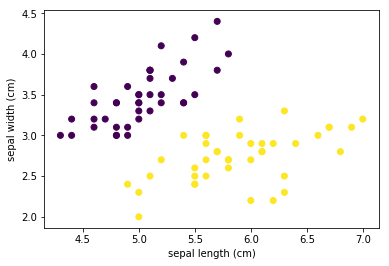

Epoch 0: Loss = 0.1533004761
Epoch 1: Loss = 0.0977748871
Epoch 2: Loss = 0.0883823156
Epoch 3: Loss = 0.0855589151
Epoch 4: Loss = 0.0902338982
Training Acc = 100.00%
Testing Acc = 95.00%


In [93]:
x = X[D<2][:, :2]
d = D[D<2]

x_train, x_test, d_train, d_test = train_test_split(x, d, test_size=0.2, random_state=5487)

plt.scatter(x_train[:,0], x_train[:,1], c=d_train)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

x_train = (x_train-x.min())/(x.max()-x.min())
x_test = (x_test-x.min())/(x.max()-x.min())

#np.random.seed(12)

input_dim = x.shape[1]
output_dim = 1
m = 1                                #k=2**m hidden neurons
q = output_dim + m*input_dim + m     #total number of qubits
N = 1024
batch_size = 20
epoch = 5
η = 3                                #learning rate

w = np.random.randn(2**m, input_dim) #random initial weights
b = np.random.randn(2**m)            #random initial biases


Q = QuantumRegister(q, 'q')
C = ClassicalRegister(q+output_dim, 'c')
simulator = Aer.get_backend('qasm_simulator')

def QNN(x):
    '''Biased QNN: x = np.array([x1,x2])'''
    circuit = QuantumCircuit(Q, C)
    wx = w*x

    circuit.h(range(q))
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.cx(0, 3)
    circuit.cu1(b[0], 0, 3)
    circuit.cx(0, 3)
    circuit.cu1(b[1], 0, 3)
    circuit.h(0)
    circuit.measure(0, 0)

    circuit.reset(Q)

    circuit.h(range(q))
    circuit.s(0)
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.cx(0, 3)
    circuit.cu1(b[0], 0, 3)
    circuit.cx(0, 3)
    circuit.cu1(b[1], 0, 3)
    circuit.h(0)
    circuit.measure(range(q), range(output_dim, q+output_dim))

    job = execute(circuit, simulator, shots=N)
    result = job.result()
    counts = result.get_counts(circuit)

    z = 0
    for i in counts:
        if i.endswith('1'): z += counts[i]/N
    
    return z, counts

for j in range(epoch):
    indices = np.random.choice(len(x_train), len(x_train), replace=False)
    for k in range(len(x_train)//batch_size):
        L, L_prime = 0, np.zeros(input_dim * 2**m + 2**m)
        for idx in indices[k*batch_size:(k+1)*batch_size]:
            z, counts = QNN(x_train[idx])
            z_prime = -0.25*np.ones(input_dim * 2**m + 2**m)
            P = np.zeros(2**(q-input_dim))
            for i in counts:
                if i.endswith('1', -2, -1): P[int(i[:q-input_dim],2)] += counts[i]/N
            for l in range(0, len(z_prime), 2**m):
                group = len(P) / 2**(l/2 + 1)
                z_prime[l] += np.sum(P[(np.arange(len(P))//group)%2 == 0])
                z_prime[l+1] += np.sum(P[(np.arange(len(P))//group)%2 == 1])
                if l//2**m < input_dim: z_prime[l:l+2**m] *= x_train[idx, l//2**m]

            L_prime += (z-d_train[idx])*z_prime / batch_size
            L += 0.5*(z-d_train[idx])**2 / batch_size
        w -= η*L_prime[:-2**m].reshape(w.shape).T
        b -= η*L_prime[-2**m:]
    print('Epoch %d: Loss = %.10f' % (j,L))
    #print(w,b)

acc = 0
for idx in range(len(x_train)):
    z, counts = QNN(x_train[idx])
    if round(z)==d_train[idx]: acc += 1/len(x_train) * 100    
print('Training Acc = %.2f%%' % acc)

acc = 0
for idx in range(len(x_test)):
    z, counts = QNN(x_test[idx])
    if round(z)==d_test[idx]: acc += 1/len(x_test) * 100
print('Testing Acc = %.2f%%' % acc)

### C. $4$-input Biased QNN
For a $4$-input biased QNN, the operation $U(w,b,x)$ is

$$U(w,b,x)=U_{ x_{ 1 } }\otimes U_{ x_{ 2 } }\otimes U_{ x_{ 3 } }\otimes U_{ x_{ 4 } }\otimes U_{ b }.$$

The derivatives of $L$ with respect to $\left\{ { w }_{ 11 },{ w }_{ 12 },{ w }_{ 21 },{ w }_{ 22 },{ w }_{ 31 },{ w }_{ 32 },{ w }_{ 41 },{ w }_{ 42 },{ b }_{ 1 },{ b }_{ 2 } \right\} $ contain the following factors

$${ P }_{ 0 }^{ 1 }+\cdots +{ P }_{ 15 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 16 }^{ 1 }+\cdots +{ P }_{ 31 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 0 }^{ 1 }+\cdots +{ P }_{ 7 }^{ 1 }+{ P }_{ 16 }^{ 1 }+\cdots +{ P }_{ 23 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 8 }^{ 1 }+\cdots +{ P }_{ 15 }^{ 1 }+{ P }_{ 24 }^{ 1 }+\cdots +{ P }_{ 31 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 0 }^{ 1 }+\cdots +{ P }_{ 3 }^{ 1 }+{ P }_{ 8 }^{ 1 }+\cdots +{ P }_{ 11 }^{ 1 }+{ P }_{ 16 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 19 }+{ P }_{ 24 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 27 }-\frac { 1 }{ 4 } \\ { P }_{ 4 }^{ 1 }+\cdots +{ P }_{ 7 }^{ 1 }+{ P }_{ 12 }^{ 1 }+\cdots +{ P }_{ 15 }^{ 1 }+{ P }_{ 20 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 23 }+{ P }_{ 28 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 31 }-\frac { 1 }{ 4 } \\ { P }_{ 0 }^{ 1 }+{ P }_{ 1 }^{ 1 }+{ P }_{ 4 }^{ 1 }+{ P }_{ 5 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 28 }+{ P }_{ 29 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 2 }^{ 1 }+{ P }_{ 3 }^{ 1 }+{ P }_{ 6 }^{ 1 }+{ P }_{ 7 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 30 }+{ P }_{ 31 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 0 }^{ 1 }+{ P }_{ 2 }^{ 1 }+{ P }_{ 4 }^{ 1 }+{ P }_{ 6 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 28 }+{ P }_{ 30 }^{ 1 }-\frac { 1 }{ 4 } \\ { P }_{ 1 }^{ 1 }+{ P }_{ 3 }^{ 1 }+{ P }_{ 5 }^{ 1 }+{ P }_{ 7 }^{ 1 }+\cdots +{ P }^{ 1 }_{ 29 }+{ P }_{ 31 }^{ 1 }-\frac { 1 }{ 4 }  $$

respectively.

#### [Model 5] Input Features: Petal Width, Petal Length, Sepal Width & Sepal Length

In [92]:
x = X[D<2]
d = D[D<2]

x_train, x_test, d_train, d_test = train_test_split(x, d, test_size=0.2, random_state=5487)

x_train = (x_train-x.min())/(x.max()-x.min())
x_test = (x_test-x.min())/(x.max()-x.min())

#np.random.seed(12)

input_dim = x.shape[1]
output_dim = 1
m = 1                                #k=2**m hidden neurons
q = output_dim + m*input_dim + m     #total number of qubits
N = 1024
batch_size = 20
epoch = 5
η = 3                                #learning rate

w = np.random.randn(2**m, input_dim) #random initial weights
b = np.random.randn(2**m)            #random initial biases


Q = QuantumRegister(q, 'q')
C = ClassicalRegister(q+output_dim, 'c')
simulator = Aer.get_backend('qasm_simulator')

def QNN(x):
    '''Biased QNN: x = np.array([x1,x2,x3,x4])'''
    circuit = QuantumCircuit(Q, C)
    wx = w*x

    circuit.h(range(q))
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.cx(0, 3)
    circuit.cu1(wx[0,2], 0, 3)
    circuit.cx(0, 3)
    circuit.cu1(wx[1,2], 0, 3)
    circuit.cx(0, 4)
    circuit.cu1(wx[0,3], 0, 4)
    circuit.cx(0, 4)
    circuit.cu1(wx[1,3], 0, 4)
    circuit.cx(0, 5)
    circuit.cu1(b[0], 0, 5)
    circuit.cx(0, 5)
    circuit.cu1(b[1], 0, 5)
    circuit.h(0)
    circuit.measure(0, 0)

    circuit.reset(Q)

    circuit.h(range(q))
    circuit.s(0)
    circuit.cx(0, 1)
    circuit.cu1(wx[0,0], 0, 1)
    circuit.cx(0, 1)
    circuit.cu1(wx[1,0], 0, 1)
    circuit.cx(0, 2)
    circuit.cu1(wx[0,1], 0, 2)
    circuit.cx(0, 2)
    circuit.cu1(wx[1,1], 0, 2)
    circuit.cx(0, 3)
    circuit.cu1(wx[0,2], 0, 3)
    circuit.cx(0, 3)
    circuit.cu1(wx[1,2], 0, 3)
    circuit.cx(0, 4)
    circuit.cu1(wx[0,3], 0, 4)
    circuit.cx(0, 4)
    circuit.cu1(wx[1,3], 0, 4)
    circuit.cx(0, 5)
    circuit.cu1(b[0], 0, 5)
    circuit.cx(0, 5)
    circuit.cu1(b[1], 0, 5)
    circuit.h(0)
    circuit.measure(range(q), range(output_dim, q+output_dim))

    job = execute(circuit, simulator, shots=N)
    result = job.result()
    counts = result.get_counts(circuit)

    z = 0
    for i in counts:
        if i.endswith('1'): z += counts[i]/N
    
    return z, counts

for j in range(epoch):
    indices = np.random.choice(len(x_train), len(x_train), replace=False)
    for k in range(len(x_train)//batch_size):
        L, L_prime = 0, np.zeros(input_dim * 2**m + 2**m)
        for idx in indices[k*batch_size:(k+1)*batch_size]:
            z, counts = QNN(x_train[idx])
            z_prime = -0.25*np.ones(input_dim * 2**m + 2**m)
            P = np.zeros(2**(q-input_dim))
            for i in counts:
                if i.endswith('1', -2, -1): P[int(i[:q-input_dim],2)] += counts[i]/N
            for l in range(0, len(z_prime), 2**m):
                group = len(P) / 2**(l/2 + 1)
                z_prime[l] += np.sum(P[(np.arange(len(P))//group)%2 == 0])
                z_prime[l+1] += np.sum(P[(np.arange(len(P))//group)%2 == 1])
                if l//2**m < input_dim: z_prime[l:l+2**m] *= x_train[idx, l//2**m]

            L_prime += (z-d_train[idx])*z_prime / batch_size
            L += 0.5*(z-d_train[idx])**2 / batch_size
        w -= η*L_prime[:-2**m].reshape(w.T.shape).T
        b -= η*L_prime[-2**m:]
    print('Epoch %d: Loss = %.10f' % (j,L))
    #print(w,b)

acc = 0
for idx in range(len(x_train)):
    z, counts = QNN(x_train[idx])
    if round(z)==d_train[idx]: acc += 1/len(x_train) * 100    
print('Training Acc = %.2f%%' % acc)

acc = 0
for idx in range(len(x_test)):
    z, counts = QNN(x_test[idx])
    if round(z)==d_test[idx]: acc += 1/len(x_test) * 100
print('Testing Acc = %.2f%%' % acc)

Epoch 0: Loss = 0.0965277195
Epoch 1: Loss = 0.1126693964
Epoch 2: Loss = 0.0997015715
Epoch 3: Loss = 0.0907203436
Epoch 4: Loss = 0.0824208975
Training Acc = 88.75%
Testing Acc = 95.00%


# III. Conclusion
From the results of the above models, we can see that all of them are able to accurately distinguish the two kinds of irises. This QNN model is easy to implement, but it might not work efficiently. During the learning process, the computation is done both on a quantum computer and a classical one. Switching between the two devices might slow down the learning. Therefore, it is worth studying whether a neural network can be run completely on a quantum computer. 

Also, the number of neurons is limited by the number of available qubits. The more features of input data and hidden neurons we want to incorporate into our QNN, the more qubits we will have to use. It is hence clear that this simple model cannot deal with high-dimensional input data (e.g., the famous $28\times 28$ handwriting pictures from `MNIST`) or a large amount of hidden neurons efficiently.

# IV. References
[1] [Ammar Daskin, "*A Simple Quantum Neural Net with a Periodic Activation Function*"](https://arxiv.org/pdf/1804.07633.pdf)